In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from pydmd import DMD
from pydmd.bopdmd import BOPDMD
from pydmd import DMDc
from scipy.signal import StateSpace, lsim, dlsim
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
import scipy
from pydmd.plotter import plot_eigs

In [2]:
# Define the state space model parameters
Amplitude = 600
Amplitude1 = 600
Frequency = 19000  # injector frequency
RunTime = .004
SampleTime = 1e-7 
L1 = 8.0141e-7 # H
L2 = 2.0462e-6 # H
M = .161 * L2  # Coupling coefficient
Mw = .1346 * L2  # Coupling coefficient
Cap = 96e-6  # F
R1 = .0025  # Ohm
R2 = .005  # Ohm
R3 = .005  # Ohm
dT = 1e-7
PhaseAngle1 = 90
PhaseAngle2 = 180
PhaseAngle3 = 270

# Scale factor in front of the entries to the A matrix 
# that are affected by mutual inductance
scalar1 = 1 / ((L2 - Mw) * ( (L2 ** 2) - (4 * M ** 2)  +  2 *L2 * Mw +  (Mw ** 2) ))
x3a =  (-L2 ** 2) * R2 + (2 * M ** 2) * R2 -L2 * Mw * R2
x3b = (-L2 ** 2) + (2 * M ** 2)-L2 * Mw
x3c = (L2 ** 2) * R2 - (2 * M ** 2) * R2 + L2 * Mw * R2 + (L2 ** 2) * R3 - (2 * M ** 2) * R3 + L2 * Mw * R3
x3d = L2 * M * R2 - M * Mw * R2
x3e = L2 * M- M * Mw
x3f = -L2 * M * R2 + M * Mw * R2 -L2 * M * R3 + M * Mw * R3
x3g = L2 * M * R2 - M * Mw * R2
x3h = L2 * M- M * Mw
x3i = -L2 * M * R2 + M * Mw * R2 -L2 * M * R3 + M * Mw * R3
x3j = - 2 * (M ** 2) * R2 + L2 * Mw * R2 + (Mw ** 2) * R2
x3k = - 2 * (M ** 2) + L2 * Mw + Mw ** 2
x3l = 2 * (M ** 2) * R2 -L2 * Mw * R2 - (Mw ** 2) * R2 + 2 * R3 * (M ** 2)-L2 * Mw * R3 - R3 * Mw ** 2

# Entries for x6 in A matrix
x6a = -L2 * M * R2 + M * Mw * R2
x6b = -L2 * M + M * Mw
x6c = L2 * M * R2 - M * Mw * R2 + L2 * M * R3 - M * Mw * R3
x6d = R2 * (L2 ** 2)- 2 * R2 * (M ** 2) + L2 * Mw * R2
x6e = (L2 ** 2)- 2 * (M ** 2) + L2 * Mw
x6f = - R2 * (L2 ** 2) + 2 * R2 * (M ** 2)-L2 * Mw * R2 - R3 * (L2 ** 2) + 2 * R3 * (M ** 2)-L2 * Mw * R3
x6g = 2 * R2 * (M ** 2)-L2 * Mw * R2 - R2 * (Mw ** 2)
x6h = 2 * (M ** 2)-L2 * Mw- (Mw ** 2)
x6i = - 2 * R2 * (M ** 2) + L2 * Mw * R2 + R2 * (Mw ** 2)- 2 * R3 * (M ** 2) + L2 * Mw * R3 + R3 * (Mw ** 2)
x6j = -L2 * M * R2 + M * Mw * R2
x6k = -L2 * M + M * Mw
x6l = L2 * M * R2 - M * Mw * R2 + L2 * M * R3 - M * Mw * R3

# Entries for x9 in A matrix
x9a = -L2 * M * R2  +  M * Mw * R2
x9b = -L2 * M  +  M * Mw
x9c = L2 * M * R2 - M * Mw * R2 *  +  L2 * M * R3  - M * Mw * R3
x9d = 2 * (M ** 2) * R2 - L2 * Mw * R2 - (Mw ** 2) * R2
x9e = 2 * (M ** 2) - L2 * Mw - (Mw ** 2)
x9f = - 2 * (M ** 2) * R2 +  L2 * Mw * R2  +  (Mw ** 2) * R2 - 2 * (M ** 2) * R3  +  L2 * Mw * R3  +  (Mw ** 2) * R3
x9g =(L2 ** 2) * R2 - 2 * (M ** 2) * R2  +  L2 * Mw * R2
x9h = (L2 ** 2) - 2 * (M ** 2)  +  L2 * Mw
x9i = - (L2 ** 2) * R2  +  2 * (M ** 2) * R2 - L2 * Mw * R2 - (L2 ** 2) * R3  +  2 * (M ** 2) * R3 - L2 * Mw * R3
x9j = -L2 * M * R2  +  M * Mw * R2
x9k = -L2 * M  +  M * Mw 
x9l = L2 * M * R2 - M * Mw * R2  +  L2 * M * R3 - M * Mw * R3

#Entries for x12 in A matrix
x12a = - 2 * (M ** 2) * R2 +  L2 * Mw * R2  + (Mw ** 2) * R2
x12b = - 2 * (M ** 2)  +  L2 * Mw  +  (Mw ** 2)
x12c = 2 * (M ** 2) * R2 - L2 * Mw * R2 - (Mw ** 2) * R2  +  2 * (M ** 2) * R3 - L2 * Mw * R3 - (Mw ** 2) * R3
x12d = L2 * M * R2 - M * Mw * R2
x12e = L2 * M - M * Mw
x12f = -L2 * M * R2  +  M * Mw * R2 - L2 * M * R3  +  M * Mw * R3
x12g = L2 * M * R2 - M * Mw * R2
x12h = L2 * M - M * Mw
x12i = -L2 * M * R2  +  M * Mw * R2 - L2 * M * R3  +  M * Mw * R3
x12j = (-L2 ** 2) * R2  +  2 * (M ** 2) * R2 - L2 * Mw * R2
x12k = (-L2 ** 2)  +  2 * (M ** 2) - L2 * Mw
x12l = (L2 ** 2) * R2 - 2 * (M ** 2) * R2  +  L2 * Mw * R2  +  (L2 ** 2) * R3 - 2 * (M ** 2) * R3  +  L2 * Mw * R3

In [3]:
# Define the state space model parameters
Amplitude = 600
Amplitude1 = 600
Frequency = 19000  # injector frequency
RunTime = .004
SampleTime = 1e-7 
L1 = 8.0141e-7 # H
L2 = 2.0462e-6 # H
M = .161 * L2  # Coupling coefficient
Mw = .1346 * L2  # Coupling coefficient
Cap = 96e-6  # F
R1 = .0025  # Ohm
R2 = .005  # Ohm
R3 = .005  # Ohm
dT = 1e-7
PhaseAngle1 = 90
PhaseAngle2 = 180
PhaseAngle3 = 270

# Scale factor in front of the entries to the A matrix 
# that are affected by mutual inductance
scalar1 = 1 / ((L2 - Mw) * ( (L2 ** 2) - (4 * M ** 2)  +  2 *L2 * Mw +  (Mw ** 2) ))
x3a =  (-L2 ** 2) * R2 + (2 * M ** 2) * R2 -L2 * Mw * R2
x3b = (-L2 ** 2) + (2 * M ** 2)-L2 * Mw
x3c = (L2 ** 2) * R2 - (2 * M ** 2) * R2 + L2 * Mw * R2 + (L2 ** 2) * R3 - (2 * M ** 2) * R3 + L2 * Mw * R3
x3d = L2 * M * R2 - M * Mw * R2
x3e = L2 * M- M * Mw
x3f = -L2 * M * R2 + M * Mw * R2 -L2 * M * R3 + M * Mw * R3
x3g = L2 * M * R2 - M * Mw * R2
x3h = L2 * M- M * Mw
x3i = -L2 * M * R2 + M * Mw * R2 -L2 * M * R3 + M * Mw * R3
x3j = - 2 * (M ** 2) * R2 + L2 * Mw * R2 + (Mw ** 2) * R2
x3k = - 2 * (M ** 2) + L2 * Mw + Mw ** 2
x3l = 2 * (M ** 2) * R2 -L2 * Mw * R2 - (Mw ** 2) * R2 + 2 * R3 * (M ** 2)-L2 * Mw * R3 - R3 * Mw ** 2

# Entries for x6 in A matrix
x6a = -L2 * M * R2 + M * Mw * R2
x6b = -L2 * M + M * Mw
x6c = L2 * M * R2 - M * Mw * R2 + L2 * M * R3 - M * Mw * R3
x6d = R2 * (L2 ** 2)- 2 * R2 * (M ** 2) + L2 * Mw * R2
x6e = (L2 ** 2)- 2 * (M ** 2) + L2 * Mw
x6f = - R2 * (L2 ** 2) + 2 * R2 * (M ** 2)-L2 * Mw * R2 - R3 * (L2 ** 2) + 2 * R3 * (M ** 2)-L2 * Mw * R3
x6g = 2 * R2 * (M ** 2)-L2 * Mw * R2 - R2 * (Mw ** 2)
x6h = 2 * (M ** 2)-L2 * Mw- (Mw ** 2)
x6i = - 2 * R2 * (M ** 2) + L2 * Mw * R2 + R2 * (Mw ** 2)- 2 * R3 * (M ** 2) + L2 * Mw * R3 + R3 * (Mw ** 2)
x6j = -L2 * M * R2 + M * Mw * R2
x6k = -L2 * M + M * Mw
x6l = L2 * M * R2 - M * Mw * R2 + L2 * M * R3 - M * Mw * R3

# Entries for x9 in A matrix
x9a = -L2 * M * R2  +  M * Mw * R2
x9b = -L2 * M  +  M * Mw
x9c = L2 * M * R2 - M * Mw * R2 *  +  L2 * M * R3  - M * Mw * R3
x9d = 2 * (M ** 2) * R2 - L2 * Mw * R2 - (Mw ** 2) * R2
x9e = 2 * (M ** 2) - L2 * Mw - (Mw ** 2)
x9f = - 2 * (M ** 2) * R2 +  L2 * Mw * R2  +  (Mw ** 2) * R2 - 2 * (M ** 2) * R3  +  L2 * Mw * R3  +  (Mw ** 2) * R3
x9g =(L2 ** 2) * R2 - 2 * (M ** 2) * R2  +  L2 * Mw * R2
x9h = (L2 ** 2) - 2 * (M ** 2)  +  L2 * Mw
x9i = - (L2 ** 2) * R2  +  2 * (M ** 2) * R2 - L2 * Mw * R2 - (L2 ** 2) * R3  +  2 * (M ** 2) * R3 - L2 * Mw * R3
x9j = -L2 * M * R2  +  M * Mw * R2
x9k = -L2 * M  +  M * Mw 
x9l = L2 * M * R2 - M * Mw * R2  +  L2 * M * R3 - M * Mw * R3

#Entries for x12 in A matrix
x12a = - 2 * (M ** 2) * R2 +  L2 * Mw * R2  + (Mw ** 2) * R2
x12b = - 2 * (M ** 2)  +  L2 * Mw  +  (Mw ** 2)
x12c = 2 * (M ** 2) * R2 - L2 * Mw * R2 - (Mw ** 2) * R2  +  2 * (M ** 2) * R3 - L2 * Mw * R3 - (Mw ** 2) * R3
x12d = L2 * M * R2 - M * Mw * R2
x12e = L2 * M - M * Mw
x12f = -L2 * M * R2  +  M * Mw * R2 - L2 * M * R3  +  M * Mw * R3
x12g = L2 * M * R2 - M * Mw * R2
x12h = L2 * M - M * Mw
x12i = -L2 * M * R2  +  M * Mw * R2 - L2 * M * R3  +  M * Mw * R3
x12j = (-L2 ** 2) * R2  +  2 * (M ** 2) * R2 - L2 * Mw * R2
x12k = (-L2 ** 2)  +  2 * (M ** 2) - L2 * Mw
x12l = (L2 ** 2) * R2 - 2 * (M ** 2) * R2  +  L2 * Mw * R2  +  (L2 ** 2) * R3 - 2 * (M ** 2) * R3  +  L2 * Mw * R3



In [4]:
A = np.array([[((-1 / L1) * (R1 + R2)), -1 / L1, R2 / L1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     [1 / Cap, 0, -1 / Cap, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     [-scalar1 * x3a, -scalar1 * x3b,-scalar1 * x3c, -scalar1 * x3d, 
      -scalar1 * x3e, -scalar1 * x3f, -scalar1 * x3g, -scalar1 * x3h, 
      -scalar1 * x3i, -scalar1 * x3j, -scalar1 * x3k, -scalar1 * x3l],
     [0, 0, 0, ((-1 / L1)*(R1 + R2)), -1 / L1, R2*1 / L1, 0, 0, 0, 0, 0, 0], 
     [0, 0, 0,  1 / Cap, 0, -1 / Cap, 0, 0, 0, 0, 0, 0], 
     [scalar1 * x6a, scalar1 * x6b, scalar1 * x6c, scalar1 * x6d, 
      scalar1 * x6e, scalar1 * x6f, scalar1 * x6g, scalar1 * x6h, 
      scalar1 * x6i, scalar1 * x6j, scalar1 * x6k, scalar1 * x6l],
     [0, 0, 0, 0, 0, 0, ((-1 / L1) * (R1 + R2)), -1 / L1, R2 / L1, 0, 0, 0], 
     [0, 0, 0, 0, 0, 0, 1 / Cap, 0, -1 / Cap, 0, 0, 0], 
     [scalar1 * x9a, scalar1 * x9b, scalar1 * x9c, scalar1 * x9d, 
      scalar1 * x9e, scalar1 * x9f, scalar1 * x9g, scalar1 * x9h, 
      scalar1 * x9i, scalar1 * x9j, scalar1 * x9k, scalar1 * x9l], 
     [0, 0, 0, 0, 0, 0, 0, 0, 0, ((-1 / L1) * (R1 + R2)), -1 / L1, R2 / L1], 
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 1 / Cap, 0, -1 / Cap], 
     [-scalar1 * x12a, -scalar1 * x12b, -scalar1 * x12c, -scalar1 * x12d,
      -scalar1 * x12e, -scalar1 * x12f, -scalar1 * x12g, -scalar1 * x12h, 
      -scalar1 * x12i, -scalar1 * x12j, -scalar1 * x12k, -scalar1 * x12l]]
)

B = np.array(
    [[1 / L1, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 1 / L1, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 1 / L1, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 1 / L1],
    [0, 0, 0, 0],
    [0, 0, 0, 0]]
)

C = np.array(
    [[0,0,1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
)

D = np.zeros((C.shape[0], C.shape[0]))

sysc = StateSpace(A, B, C, D) 
print(A.shape, C.shape, B.shape, D.shape)
print(np.linalg.eigvals(A)) 

(12, 12) (4, 12) (12, 4) (4, 4)
[-5374.04778628+128310.86801552j -5374.04778628-128310.86801552j
 -6150.9991369 +138653.66264826j -6150.9991369 -138653.66264826j
 -6044.9626896 +137273.04653728j -6044.9626896 -137273.04653728j
 -6044.96263763+137273.04653074j -6044.96263763-137273.04653074j
 -2052.57854051     +0.j         -2915.80446125     +0.j
 -2915.80452169     +0.j         -2983.64806906     +0.j        ]


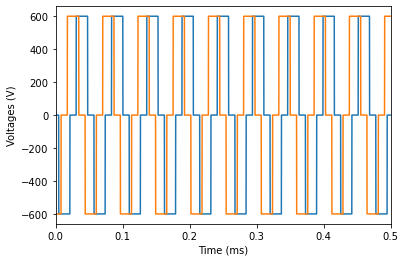

In [5]:
time = np.linspace(0, RunTime, int(RunTime / SampleTime) + 1, endpoint=True)
data = loadmat('voltages.mat')
voltage1 = data['newVoltage']
voltage2 = data['newVoltageShift3']
voltage3 = data['newVoltageShift1']
voltage4 = data['newVoltageShift2']
plt.plot(time * 1e3, voltage1)
plt.plot(time * 1e3, voltage3)
plt.xlim(0, 0.5)
plt.xlabel('Time (ms)')
plt.ylabel('Voltages (V)')
plt.show()

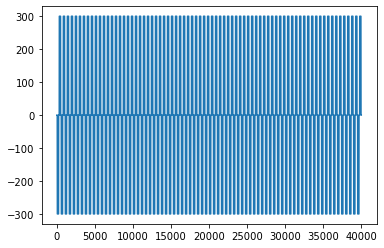

In [6]:
plt.plot(voltage1/2)

7419.141658465024


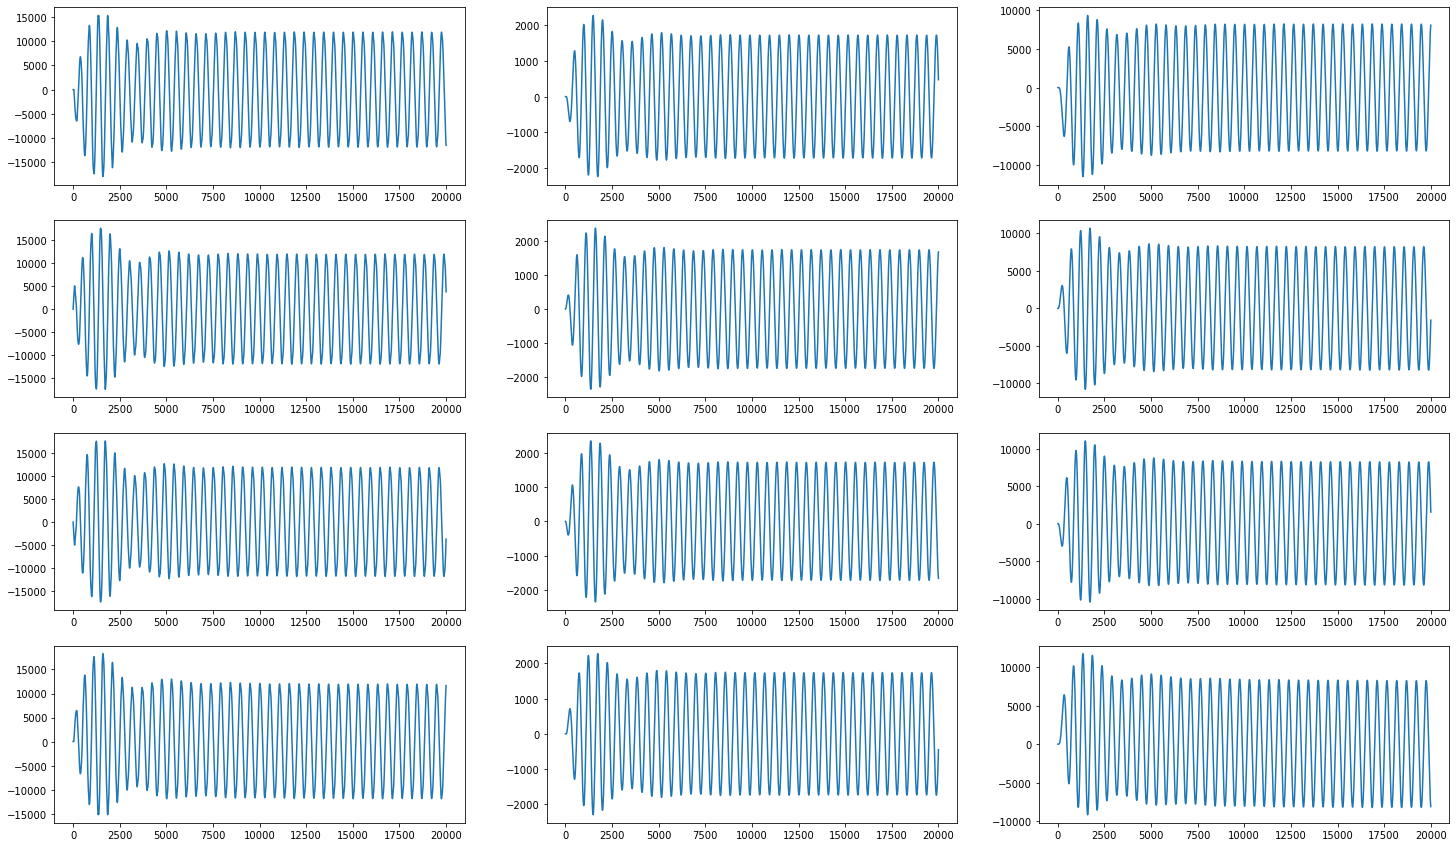

In [7]:
voltages = np.hstack([voltage1, voltage2, voltage3, voltage4])

#Simulating 40001 samples takes too much memory from my poor laptop, so I'm going to cut the shot in half
half_time = time[0:int(len(time)/2)]
half_voltages = voltages[0:int(len(time)/2)]

tout, yout, xout = lsim(
    sysc, 
    half_voltages, 
    half_time
)



tout_test, yout, xout_test_total = lsim(
    sysc, 
    half_voltages/3, #Dropping ampltidue by factor of three to make a rudimentary test set
    half_time
    
)
plt.figure(figsize = (25,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(xout[:,i])
    
print(np.linalg.cond(xout))


In [8]:
#Start with bop,opt, and exact dmd

#Wen we try dmd with 12 modes we get pretty shit prediction. Looking ath the singular values of the dynamics matrix
#indicates that using a rank 4 approximation does the best job of actually capturing the data.
optdmd = BOPDMD(svd_rank = 4,num_trials = 0,compute_A = True)
bopdmd = BOPDMD(svd_rank = 4,num_trials = 25,compute_A = True)
#dmd = DMD(svd_rank = 12, tlsq_rank = 12,exact = True, opt = True)
#Fit all three of our models

#need to transpose our data, and remember this has 10x less samples than the full simulation data so our algorithm can converge

xout_train = xout.T
xout_test = xout_test_total.T

print(np.shape(xout_test))


time_train = tout
time_test = tout_test

optdmd.fit(xout_train,time_train)
bopdmd.fit(xout_train,time_train)

# dmd.fit(xout_train)

#get the statistics for forecasting
reconstruction_mean, reconstruction_variance = bopdmd.forecast(time_train)
forecast_mean, forecast_variance = bopdmd.forecast(time_test)



(12, 20000)


C:\Users\ducks\anaconda3\lib\site-packages\pydmd\plotter.py:189: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x000001F2C5FC2E20>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(


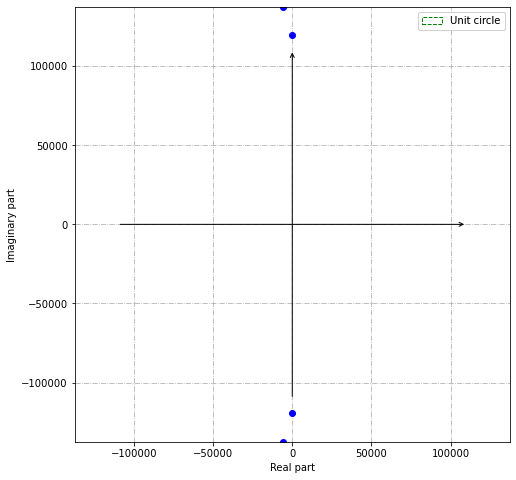

In [9]:
# plt.scatter(np.imag(optdmd.eigs),np.real(optdmd.eigs))

# # plt.scatter(np.imag(bopdmd.eigs),np.real(bopdmd.eigs))

# plt.scatter(np.imag(np.linalg.eigvals(A)),np.real(np.linalg.eigvals(A)))

plot_eigs(bopdmd,show_axes = True)


In [10]:
bopdmd.eigs

array([-6.01081075e+03-137250.46664579j,  2.01249448e+00-119380.74981414j,
        2.01249448e+00+119380.74981414j, -6.01081075e+03+137250.46664579j])

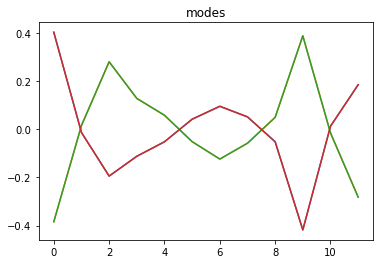

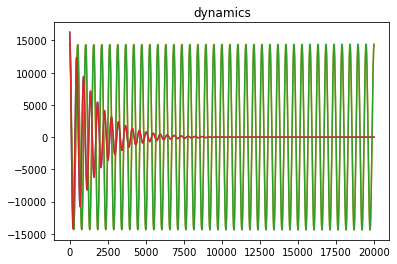

In [11]:
for mode in bopdmd.modes.T:
    plt.plot(mode.real)
    plt.title('modes')
plt.show()

for dynamic in bopdmd.dynamics:
    plt.plot(dynamic.real)
    plt.title('dynamics')
plt.show()

(4, 20000)
(12, 4)


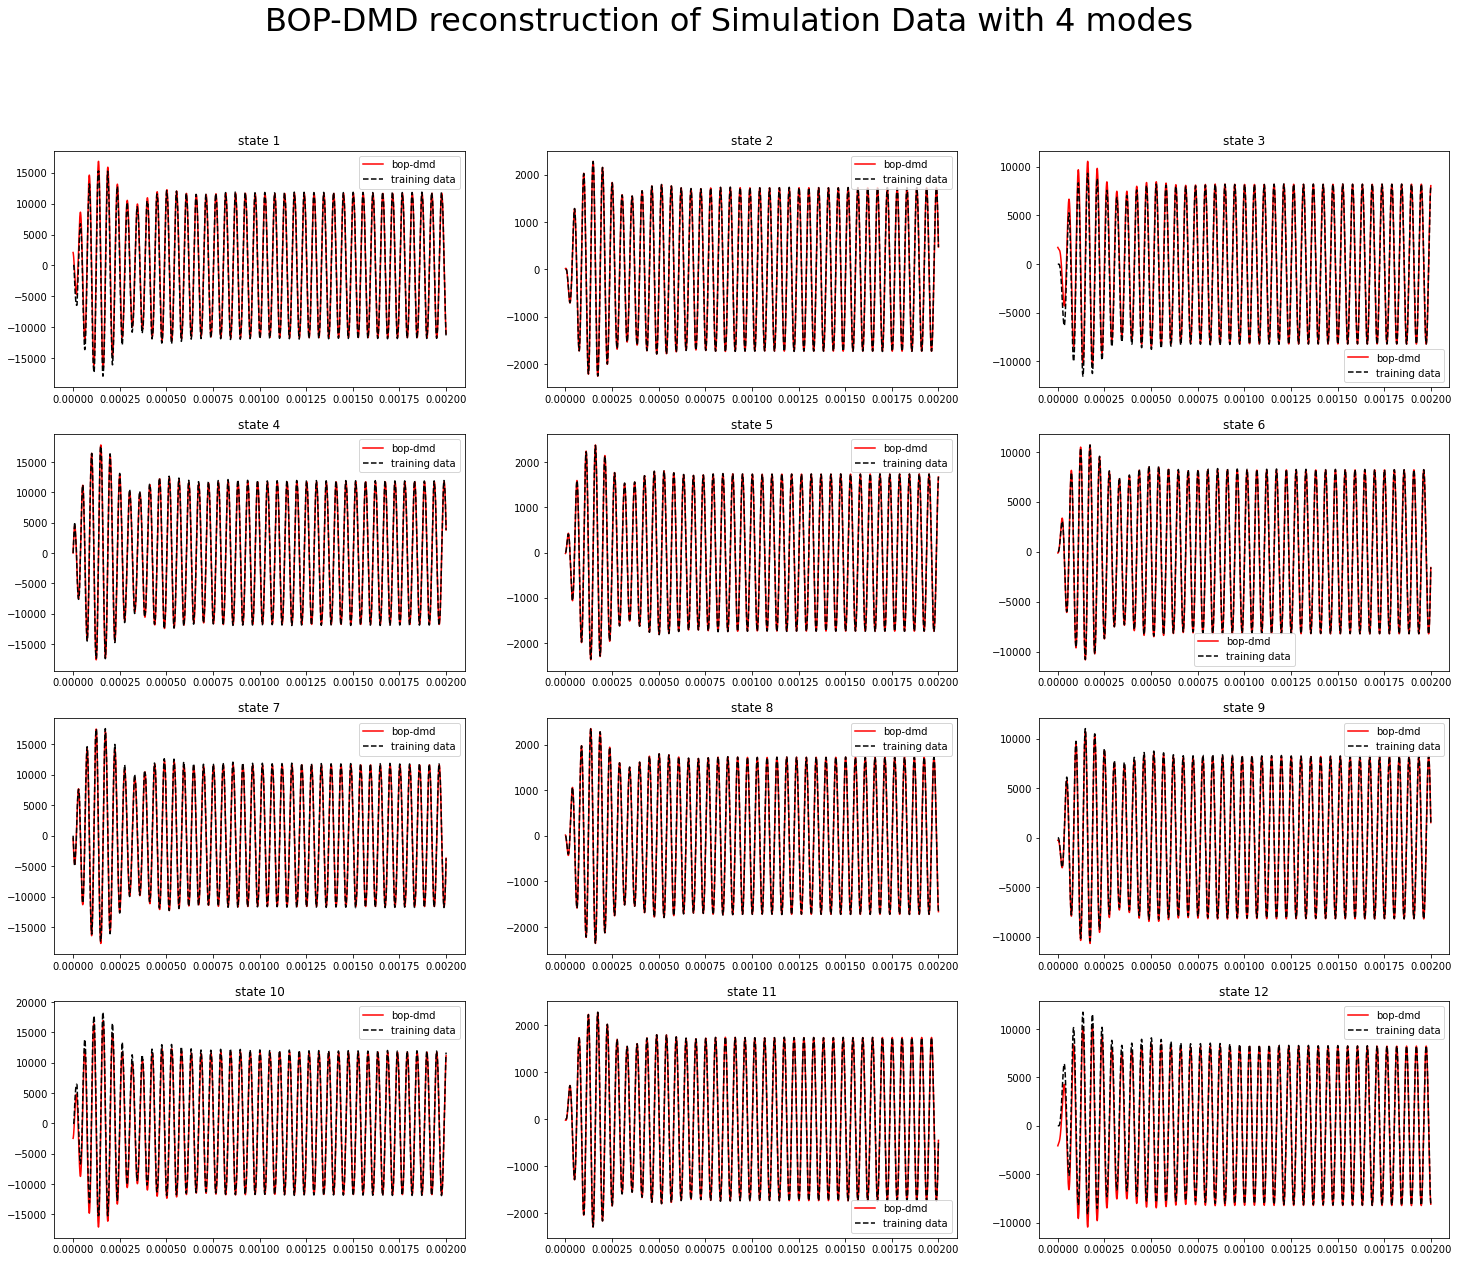

In [12]:
print(np.shape(bopdmd.dynamics.real))
print(np.shape(bopdmd.modes.real))

bopdmd_states = bopdmd.modes@bopdmd.dynamics

count = 0
plt.figure(figsize = (25,20))
plt.suptitle('BOP-DMD reconstruction of Simulation Data with 4 modes',fontsize = 32)
for state,true in zip(bopdmd_states,xout_train):
    plt.subplot(4,3,count+1)
    plt.plot(half_time,state.real,'r')
    plt.plot(half_time,true,'k--')
    plt.legend(['bop-dmd','training data'])
    plt.title(f'state {count+1}')
    count = count + 1
    

0.9874105886321796


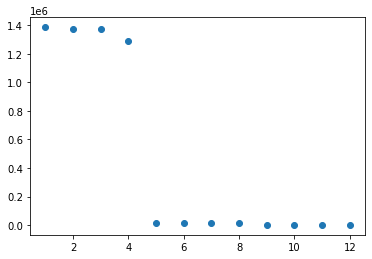

In [13]:
u,s,vt = np.linalg.svd(A)

plt.scatter(np.linspace(1,len(s),len(s)),s)

print(np.sum(s[0:4])/np.sum(s))

In [14]:
A_bop = bopdmd.A

sys_dmd = StateSpace(A_bop,B,C,D)

tout_dmd,yout_dmd,xout_dmd = lsim(
sys_dmd,
half_voltages,
half_time
)

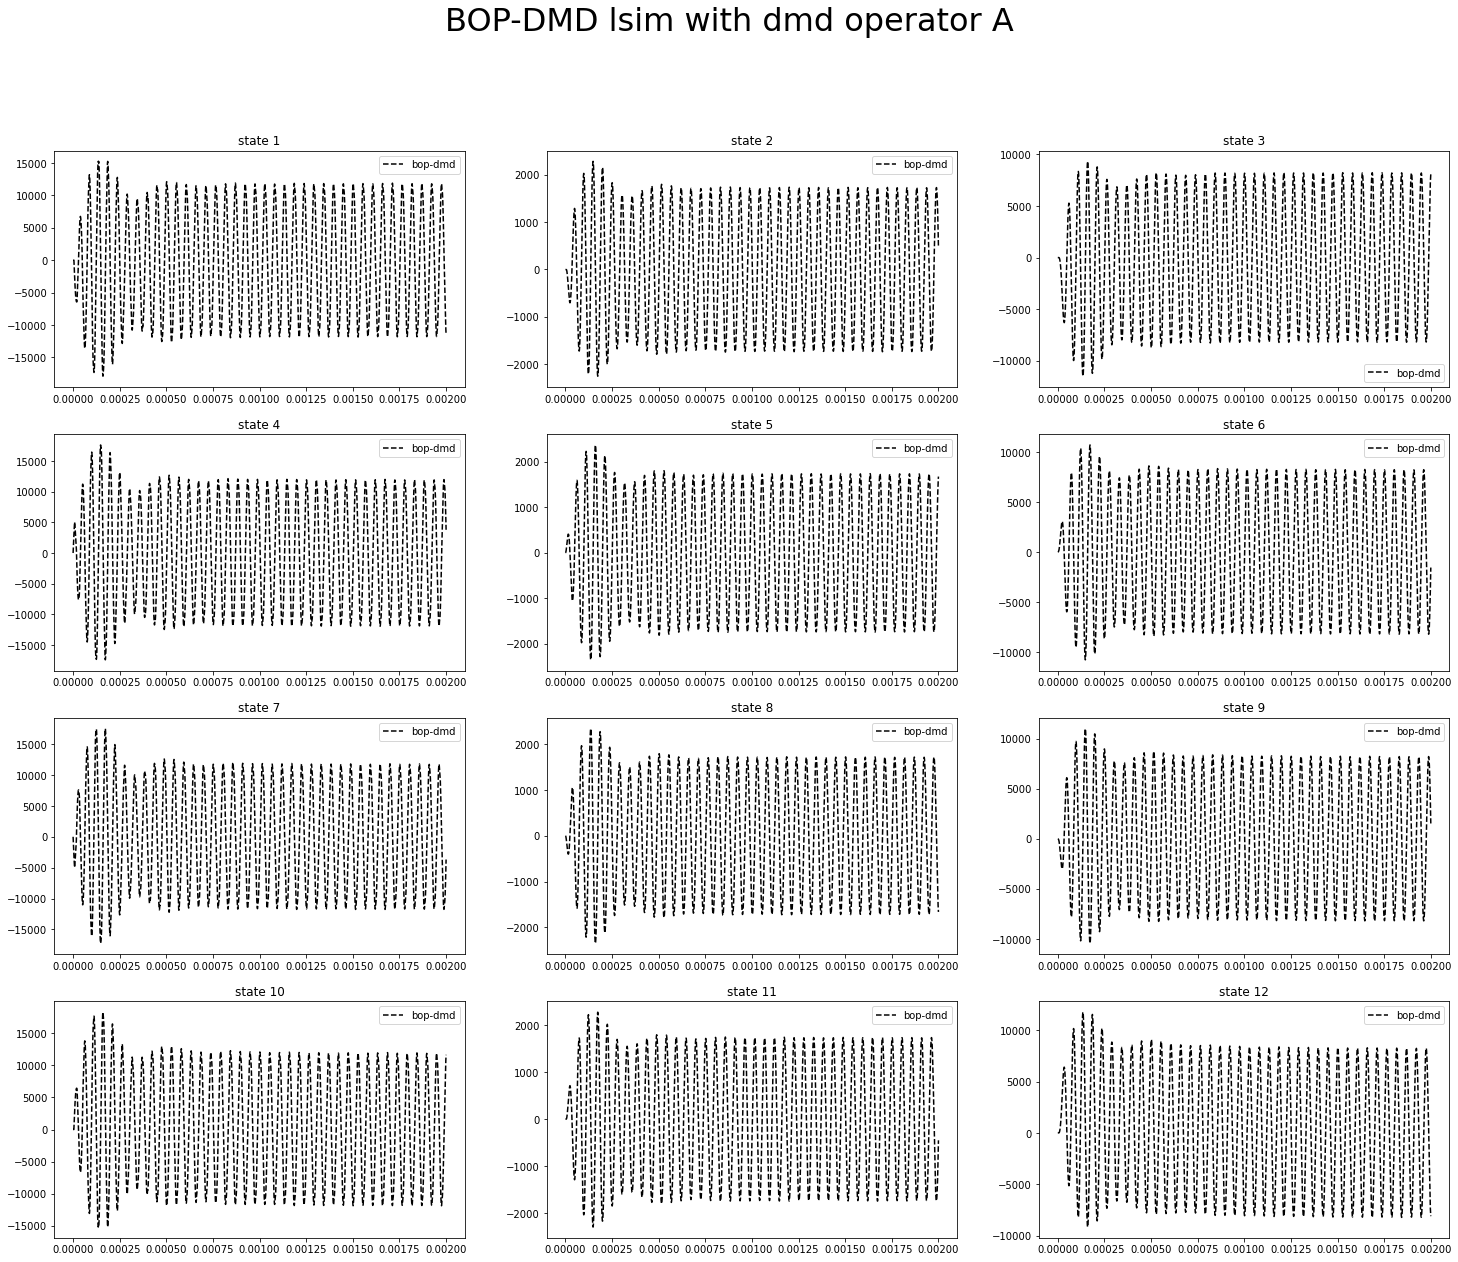

In [15]:
plt.figure(figsize = (25,20))
count = 0
plt.suptitle('BOP-DMD lsim with dmd operator A',fontsize = 32)
for state,true in zip(xout_dmd.T,xout_train):
    plt.subplot(4,3,count+1)
#     plt.plot(half_time,state.real,'r')
    plt.plot(half_time,true,'k--')
    plt.legend(['bop-dmd','training data'])
    plt.title(f'state {count+1}')
    count = count + 1

## Let's give dmdc a try...

In [16]:
print(np.shape(half_voltages))
print(np.shape(xout_train))

(20000, 4)
(12, 20000)


[ 1.22146425e+03+2.51378229e+05j  1.22146425e+03-2.51378229e+05j
 -3.14479396e+04+3.00709596e+04j -3.14479396e+04-3.00709596e+04j
  9.83328180e-01+0.00000000e+00j  1.01499228e+00+0.00000000e+00j
  1.00099296e+00+1.97975712e-02j  1.00099296e+00-1.97975712e-02j
  9.99316108e-01+1.37434512e-02j  9.99316108e-01-1.37434512e-02j
  1.00089424e+00+0.00000000e+00j  9.99465938e-01+0.00000000e+00j]


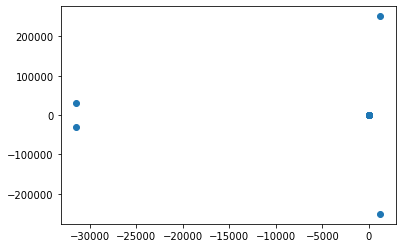

In [17]:
dmdc = DMDc(svd_rank = -1)
dmdc.fit(xout_train,half_voltages.T[:,:-1],B=B)

Atilde = dmdc.operator.as_numpy_array


plt.scatter(np.real(np.linalg.eigvals(Atilde)),np.imag(np.linalg.eigvals(Atilde)))

print(np.linalg.eigvals(Atilde))

In [18]:


#matrix that goes from 1st, to 2nd to last snapshot
xout_train_first = xout_train[:,:-1]
#matrix that takes snapshots from 2nd, to the last snapshot
xout_train_second = xout_train[:,1::]

u,s,vt = np.linalg.svd(xout_train_first, full_matrices = False)

print(np.shape(xout_train_second))

rank = 4

u_tilde = u[:,0:rank]
s = s[0:rank]
s_tilde = np.diag(s)
vt_tilde = vt[0:rank,:]

A_tilde = (xout_train_second-B@half_voltages.T[:,:-1])@vt_tilde.T@np.linalg.inv(s_tilde)@np.conj(u_tilde).T



(12, 19999)


In [19]:
print(np.linalg.eigvals(A_tilde))

[-1.07250616e+04+2.24853403e+04j -1.07250616e+04-2.24853403e+04j
  6.84846057e+02+0.00000000e+00j  1.95153797e+00+0.00000000e+00j
  3.98884684e-12+0.00000000e+00j  3.51094743e-13+0.00000000e+00j
 -2.25667999e-13+0.00000000e+00j -2.04296659e-14+0.00000000e+00j
 -1.24044520e-15+0.00000000e+00j  4.54888645e-17+0.00000000e+00j
 -4.60888160e-17+1.87339395e-18j -4.60888160e-17-1.87339395e-18j]


In [20]:
plt.figure(figsize = (25,20))
plt.suptitle('DMDc states against training data',fontsize = 32)
count = 0
for state,true in zip(dmdc_states,xout_train):
    plt.subplot(4,3,count+1)
    plt.plot(half_time,state.real,'r')
#     plt.plot(half_time,true,'k--')
    plt.legend(['DMDc','training data'])
    plt.title(f'state {count+1}')
    count = count + 1

NameError: name 'dmdc_states' is not defined

<Figure size 1800x1440 with 0 Axes>